# 3D U-Net Model for Lung CT Image Segmentation

## Overview

This notebook demonstrates the implementation and training of a 3D U-Net model for segmenting lung structures from 3D CT scans.

## Key Features

- **Model Architecture**: Utilizes a 3D U-Net network.
- **Loss Function**: Combines Mean Absolute Error (MAE) and Dice score
- **Training**: Includes setup for training


In [1]:
# Parameters

# specific number for file name
spec = 5

# select test(1) or training(0)
test = 0

# paramters training
batch_size = 1
number_of_epochs = 100

In [2]:
cd /data-synology/anlee/

/data-synology/anlee


In [3]:
ls

 COPDGene/            filenamestrain.npy*   softmasks/           'testing ccc'/
 features/            filenamesval.npy*     softmasks_summer23/   testnpy.npy*
 features_CCC/        heatmaps/             test*
 features_CCC_meas/   saliency/             test2*
 filenamestest.npy*   smoothgrad/           test3*


In [4]:
# includes & imports
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #for CPU ""

import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
#import nilearn as nil
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

# random seeds
np.random.seed(16)
tf.random.set_seed(16)
tf.keras.utils.set_random_seed(16)

2024-04-10 20:26:48.623474: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 20:26:48.623512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 20:26:48.623534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 20:26:48.633179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-10 20:26:50.358238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 20:26:50.363216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 20:26:50.364509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Build an input pipeline with image paths

In [5]:
# get image pathes for input and target images
from tqdm import tqdm

root_directory = '/data-synology/anlee/COPDGene/'  # Replace with the actual path to your root directory
inputImageName = ('insp_ct_ds.nii') #('insp_ct.nii')
outputImageName = ('exp_ct_deform_ds.nii')  # Extensions of the target image files
maskInspImageName = ('insp_mask_cat.nii')  # Mask image
# maskDefExpImageName = ('exp_mask_deform_cat.nii')  # Mask image


def search_images(directory, image_list, name):
  for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith(name):
                image_path = os.path.join(root, file)
                image_list.append(image_path.replace('\0', ''))  # Add the image path to the list, replace termination character

# Create an empty list to store image paths
inputImagePath = []
outputImagePath = []
maskInspImagePath = []
#maskDefExpImagePath = []

# Call the search_image function with the root directory
search_images(root_directory, inputImagePath, inputImageName)
search_images(root_directory, outputImagePath, outputImageName)
search_images(root_directory, maskInspImagePath, maskInspImageName)
#search_images(root_directory, maskDefExpImagePath, maskDefExpImageName)

# check if path loaded
if inputImagePath:
    print("Image input paths:")
    for path in inputImagePath[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")

if outputImagePath:
    print("Image ouput paths:")
    for path in outputImagePath[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")
    
if maskInspImagePath:
    print("Image mask insp paths:")
    for path in maskInspImagePath[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")
    
#if maskDefExpImagePath:
#    print("Image mask defExp paths:")
#    for path in maskDefExpImagePath[:5]:
#        print(path)
#else:
#    print("No image files found in the directory tree.")

9116it [00:21, 427.51it/s]
9116it [00:17, 526.58it/s]
9116it [00:17, 528.78it/s]


Image input paths:
/data-synology/anlee/COPDGene/26055P_PIT_COPD_26055P_PIT_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/26056R_HAR_COPD_26056R_HAR_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/26057T_PIT_COPD_26057T_PIT_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/26058V_HAR_COPD_26058V_HAR_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/26059X_HAR_COPD_26059X_HAR_COPD/insp_ct_ds.nii
Image ouput paths:
/data-synology/anlee/COPDGene/26055P_PIT_COPD_26055P_PIT_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/26056R_HAR_COPD_26056R_HAR_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/26057T_PIT_COPD_26057T_PIT_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/26058V_HAR_COPD_26058V_HAR_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/26059X_HAR_COPD_26059X_HAR_COPD/exp_ct_deform_ds.nii
Image mask insp paths:
/data-synology/anlee/COPDGene/26055P_PIT_COPD_26055P_PIT_COPD/insp_mask_cat.nii
/data-synology/anlee/COPDGene/26056R_HAR_COPD_26056R_HAR_CO

In [6]:
from sklearn.model_selection import train_test_split

# Convert image paths to lists
inputImagePath = list(inputImagePath)
outputImagePath = list(outputImagePath)
maskInspImagePath = list(maskInspImagePath)
#maskDefExpImagePath = list(maskDefExpImagePath)

# Split the data into training and test sets list
train_input, test_input, train_output, test_output, train_insp_mask, test_insp_mask = train_test_split(
    inputImagePath, outputImagePath, maskInspImagePath, test_size=0.3, random_state=42)

# Split the data into test and validation sets list
val_input, test_input, val_output, test_output, val_insp_mask, test_insp_mask = train_test_split(
    test_input, test_output, test_insp_mask, test_size=0.5, random_state=42)

print('training data: ' + str(len(train_input)))
print('validation data: ' + str(len(val_input)))
print('test data: ' + str(len(test_input)))
print('train mask inspiratory data: ' + str(len(train_insp_mask)))
print('test mask inspiratory data: ' + str(len(test_insp_mask)))
#print('train mask expiratory data: ' + str(len(train_exp_mask)))
#print('test mask expiratory data: ' + str(len(test_exp_mask)))

if train_input:
    print("Image input paths:")
    for path in train_input[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")

if train_output:
    print("Image ouput paths:")
    for path in train_output[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")
    
if train_insp_mask:
    print("Image mask inspiratory paths:")
    for path in train_insp_mask[:5]:
        print(path)
else:
    print("No image files found in the directory tree.")
    
#if train_exp_mask:
#    print("Image mask inspiratory paths:")
#    for path in train_exp_mask[:5]:
#        print(path)
#else:
#    print("No image files found in the directory tree.")

training data: 6380
validation data: 1367
test data: 1368
train mask inspiratory data: 6380
test mask inspiratory data: 1368
Image input paths:
/data-synology/anlee/COPDGene/23967R_USD_COPD_23967R_USD_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/13654Q_UMC_COPD_13654Q_UMC_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/20221C_UMC_COPD_20221C_UMC_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/25112W_JHU_COPD_25112W_JHU_COPD/insp_ct_ds.nii
/data-synology/anlee/COPDGene/10561U_HAR_COPD_10561U_HAR_COPD/insp_ct_ds.nii
Image ouput paths:
/data-synology/anlee/COPDGene/23967R_USD_COPD_23967R_USD_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/13654Q_UMC_COPD_13654Q_UMC_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/20221C_UMC_COPD_20221C_UMC_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/25112W_JHU_COPD_25112W_JHU_COPD/exp_ct_deform_ds.nii
/data-synology/anlee/COPDGene/10561U_HAR_COPD_10561U_HAR_COPD/exp_ct_deform_ds.nii
Image mask inspiratory paths:
/data-s

/data-synology/anlee/COPDGene/23967R_USD_COPD_23967R_USD_COPD/insp_ct_ds.nii


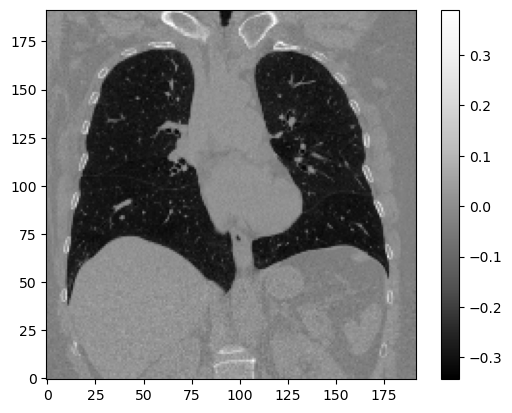

In [7]:
print(train_input[0])
image_dataX = nib.load(train_input[0])
image = image_dataX.get_fdata()
i,j,k = np.array(image.shape) // 2  # middle slice along the first axis

plt.imshow((image[i, :, :].T)/3000, cmap='Greys_r', origin='lower')
plt.colorbar()
plt.show()

In [8]:
image_data = np.array(image/3000)

pixel_min = image_data.min()
pixel_max = image_data.max()

# Print the pixel range
print("Pixel range: {} - {}".format(pixel_min, pixel_max))

Pixel range: -1.2010332845052083 - 0.6181819254557291


In [9]:
# image function to load images
def load_image_scale(file_path):
    
    # load nibable image
    image_data = nib.load(file_path).get_fdata()

    # scale image
    image = (image_data / 3000) 
    
    return image

In [10]:
# image function to load images
def load_image(file_path):
    
    # load nibable image
    image_data = nib.load(file_path).get_fdata()

    image = image_data
    
    return image

In [11]:
def load_image_mask(file_path):
    
    image_data = nib.load(file_path).get_fdata()

    mask = image_data

    # binary image mask
    binary_mask_slice = np.where((mask > 0) & (mask < 6), 1, 0)
    
    return binary_mask_slice

In [12]:
os.getcwd()

'/data-synology/anlee'

# Implement the U-Net Generator Model

In [13]:
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, Activation, Concatenate, Dropout, BatchNormalization, LeakyReLU, UpSampling3D
from keras.regularizers import l2

# Define an encoder block for 3D data
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # Weight initialization
    init = RandomNormal(stddev=0.02)
    # Add downsampling layer
    g = Conv3D(n_filters, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)  # kernel_regularizer=l2(0.001) if needed
    # Conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # Leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# Define a decoder block for 3D data
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # Weight initialization
    init = RandomNormal(stddev=0.02)
    # Add upsampling layer
    g = UpSampling3D(size=(2,2,2))(layer_in)
    g = Conv3D(n_filters, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(g)  # kernel_regularizer=l2(0.001) if needed
    # Add batch normalization
    g = BatchNormalization()(g, training=True)
    # Conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # Merge with skip connection
    g = Concatenate()([g, skip_in])
    # Relu activation
    g = Activation('relu')(g)
    return g

# Define the standalone generator model for 3D data
def define_generator(image_shape=(192,192,192,1)):  # Adjusted for 3D image shape
    # Weight initialization
    init = RandomNormal(stddev=0.02)
    # Image input
    in_image = Input(shape=image_shape)
    # Encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    # Bottom of the U-Net
    b = Conv3D(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(e6)
    b = Activation('relu')(b)
    # Decoder model
    d1 = decoder_block(b, e5, 512)
    d2 = decoder_block(d1, e4, 512)
    d3 = decoder_block(d2, e3, 512, dropout=False)
    d4 = decoder_block(d3, e2, 256, dropout=False)
    d5 = decoder_block(d4, e1, 128, dropout=False)
    # Output
    g = UpSampling3D(size=(2,2,2))(d5)
    g1 = Conv3D(1, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(g)
    g2 = Conv3D(1, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(g)
    out_image = Activation('linear', name='output1')(g1)
    out_mask = Activation('sigmoid', name='output2')(g2)
    # Define model
    model = Model(in_image, [out_image, out_mask])
    return model

# Define image shape for 3D
image_shape = (192,192,192,1)  # Adjusted for 3D volume

# Create the model
model = define_generator(image_shape)

# summarize the model
# model.summary()

# plot the model
# plot_model(model, to_file='/data-synology/tkeller/generator_model_plot.png', show_shapes=True, show_layer_names=True)batch_size

2024-04-10 20:27:47.159021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 20:27:47.160390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 20:27:47.161661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Update Model Weights

In [14]:
# select test or train data, for testing purpese
if test == 1:
    train_input_smaller = train_input[0::128] # every 16th item, starting from the 1th item
    train_output_smaller = train_output[0::128] # every 16th item starting from the 1th item
    train_mask_insp_smaller = train_insp_mask[0::128]
    #train_mask_exp_smaller = train_exp_mask[0::128]
    val_input_smaller = val_input[0::128]
    val_output_smaller = val_output[0::128] 
    val_mask_insp_smaller = val_insp_mask[0::128]
    #val_mask_exp_smaller = val_exp_mask[0::128]


    train_dataset_paths = (train_input_smaller, train_output_smaller)
    val_dataset_paths = (val_input_smaller, val_output_smaller)
    train_mask_insp_paths = train_mask_insp_smaller
    val_mask_insp_paths = val_mask_insp_smaller
    #train_mask_exp_paths = train_mask_exp_smaller
    #val_mask_exp_paths = val_mask_exp_smaller
    
else:
    train_dataset_paths = (train_input, train_output)
    train_mask_insp_paths = train_insp_mask
    #train_mask_exp_paths = train_exp_mask
    val_dataset_paths = (val_input, val_output)
    val_mask_insp_paths = val_insp_mask
    #val_mask_exp_paths = val_exp_mask

# calucalte steps and so on
length = len(train_dataset_paths[0])
length2 = len(val_dataset_paths[0])
print('length train:')
print(length)

print('length val:')
print(length2)

# calculate steps per epoch and validation steps
steps_per_epoch = len(train_dataset_paths[0]) // batch_size
print('steps_per_epoch: ' + str(steps_per_epoch))

validation_steps = len(val_dataset_paths[0]) // batch_size
print('validation_steps: ' + str(validation_steps))

# calculate the number of training iterations
number_of_steps_total = int(steps_per_epoch * number_of_epochs)
print('number_of_steps_total: ' + str(number_of_steps_total))

# create directory
try:
    os.mkdir(f"/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}")
    os.mkdir(f"/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}/plots")

except Exception as e:
    print("An error occurred:", str(e))

length train:
6380
length val:
1367
steps_per_epoch: 6380
validation_steps: 1367
number_of_steps_total: 638000


In [15]:
from random import shuffle

# define image generator
# Output: yield np.array(train_input_images), [np.array(train_output_images),np.array(train_output_mask)]

def data_generator(paths, mask_insp_paths, batch_size):
    train_input_paths, train_output_paths = paths
    
    num_samples = len(train_input_paths)
    indices = list(range(num_samples))
    
    while True:
        # Shuffle indices at the beginning of each epoch
        shuffle(indices)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            
            train_input_images = []
            train_output_images = []
            train_output_mask = []
            
            for idx in batch_indices:
                
                # load mask
                mask = load_image_mask(mask_insp_paths[idx])
                # load input image
                insp_image = load_image_scale(train_input_paths[idx])
                # mask input image
                input_image = insp_image * mask
                # load deformed exp image
                defexp_image = load_image(train_output_paths[idx])
                # calculate subtraction and mask it
                output_image = defexp_image * mask

                diseas_image = (output_image - insp_image) 
                diseas_mask = np.where(diseas_image < 1/30 , 1, 0) * mask # check
                
                # append images to input and output train
                train_input_images.append(np.expand_dims(input_image, -1))
                train_output_images.append(np.expand_dims(output_image, -1))
                train_output_mask.append(np.expand_dims(diseas_mask, -1))
            
            yield np.array(train_input_images), [np.array(train_output_images),np.array(train_output_mask)]


In [16]:
# create data generators for test and validation
training_generator = data_generator(train_dataset_paths, train_mask_insp_paths, batch_size)
val_generator = data_generator(val_dataset_paths, val_mask_insp_paths, batch_size)

In [17]:
# Example to test the generator output
gen = data_generator(train_dataset_paths, train_mask_insp_paths, batch_size)
inputs, (outputs, outputs2) = next(gen)

print(inputs.shape, outputs.shape, outputs2.shape)

# visualize a slice from the first volume in the batch
# plt.imshow(inputs[0, :, :, 95, 0], cmap='gray')  # Adjust indexing based on your data shape
# plt.show()


(1, 192, 192, 192, 1) (1, 192, 192, 192, 1) (1, 192, 192, 192, 1)


In [18]:
# plot function for training and validation
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        
    def on_epoch_end(self, epoch, logs={}):
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        plt.clf()  # Clear the current figure contents
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.title("Training and Validation Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        # Save the figure
        plt.savefig(f'/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}/plots/epoch_{epoch}_plot.png')
        # plt.show()

plot_losses = PlotLosses()

In [19]:
# log files
csv_logger = tf.keras.callbacks.CSVLogger(f'/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}/training.log')
# save model val imporve
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False)

In [20]:
# dice coefficent calcualtion
def dice_coefficient(y_true, y_pred, threshold=100, scale=3000):
    
    epsilon = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + epsilon
    
    dice = (2. * intersection + epsilon) / union
    return (1 - dice)  # For loss, return 1 - dice to minimize

In [ ]:
from tensorflow.keras.optimizers import Adam

# model compile
opt = Adam(learning_rate=0.0002, beta_1=0.5) # 0.0002

model.compile(optimizer=opt,
              loss={'output1': 'mae', 'output2': dice_coefficient},
              metrics={'output1': ['mae'], 'output2': [dice_coefficient]},
              loss_weights={'output1': 0.0, 'output2': 1.0})

# model fit, start training
model.fit(training_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          batch_size = batch_size,
          epochs=number_of_epochs,
          callbacks=[csv_logger, model_checkpoint, plot_losses])

print('Training/Validation done')

In [ ]:
os.getcwd()

In [ ]:
# Read data from log file
with open(f'/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}/training.log', 'r') as f:
    lines = f.readlines()

# Skip the header
lines = lines[1:]

# Split data
epochs = []
loss = []
val_loss = []

for line in lines:
    data = line.strip().split(',')
    epochs.append(int(data[0]))
    loss.append(float(data[1]))
    val_loss.append(float(data[2]))

# Plot data
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()


Image generator


In [ ]:
# load model

In [ ]:
def generate_images(model, test_input, tar, tar_mask):
    # Get the prediction from the model
    prediction, prediction_mask = model(test_input, training=True)

    # Convert back to normal values if needed
    prediction = prediction * 3000
    
    for j in range(3):  # display images for the first 3 examples
        plt.figure(figsize=(20, 10))

        # Calculate the index of the middle slice
        middle_slice_idx = test_input.shape[1] // 2  # test_input.shape[1] is the depth dimension

        # Select the middle slice for each input, output, and prediction
        display_list = [
            test_input[j, middle_slice_idx, :, :, 0],  # Middle slice of the input
            tar[j, middle_slice_idx, :, :, 0],         # Middle slice of the ground truth output
            prediction[j, middle_slice_idx, :, :, 0],  # Middle slice of the predicted output
            tar_mask[j, middle_slice_idx, :, :, 0],    # Middle slice of the ground truth mask
            prediction_mask[j, middle_slice_idx, :, :, 0]  # Middle slice of the predicted mask
        ]

        title = ['Input Image', 'Ground Truth Image', 'Predicted Image', 'Ground Truth Mask', 'Predicted Mask']

        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.title(title[i])
            # Display the mask images differently if needed
            if i >= 3:  # Adjust threshold or colormap for masks if necessary
                plt.imshow(display_list[i] > 0.5, cmap='gray', origin='lower')
            else:
                plt.imshow(display_list[i], cmap='gray', origin='lower')
            plt.axis('off')

        plt.savefig(f'/data-synology/tkeller/Outputs/3D_nsteps{number_of_steps_total}_batch{batch_size}_DiceLoss_{spec}/ExOutputImage_{number_of_steps_total}_{batch_size}_{j}.png', dpi=500)
        plt.show()


Create datatrain for Image generator

In [ ]:
from random import sample

# validation data is used to check if model works correct

n_samples = 3
random_indices = sample(range(len(val_input)), n_samples)
print(random_indices)

# pick n_samples random samples from validation dataset
random_input_paths_val = [val_input[idx] for idx in random_indices]
random_output_paths_val = [val_output[idx] for idx in random_indices]
random_mask_insp_paths_val = [val_insp_mask[idx] for idx in random_indices]
# random_mask_exp_paths_val = [val_exp_mask[idx] for idx in random_indices]


val_input_images = []
val_output_images = []

#for input_path, output_path in zip(test_input, test_output):
for input_path, output_path, mask_insp_path in zip(random_input_paths_val, random_output_paths_val, random_mask_insp_paths_val):
    # select random slice of 3D image: 0-191
    mask = load_image_mask(mask_insp_path)
    input_image = load_image_scale(input_path) * mask
    defexp_image = load_image(output_path)
    output_image = defexp_image * mask
    val_input_images.append(np.expand_dims(input_image, -1))
    val_output_images.append(np.expand_dims(output_image, -1))

#val_dataset = (val_input_images, val_output_images)

In [ ]:
# create np.array
dataset = val_input_images, val_output_images
val_dataset = np.array(dataset)


Generate "Fake" Image predicitons

In [ ]:
#for element in test_dataset[1]:

dataset = val_dataset
trainA2 = dataset[0]
trainB2 = dataset[1]

generate_images(model, trainA2, trainB2)